## DB connection 

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

client = MongoClient() # we run on localhost and default port
db = client['spotify']

## Get collections

In [2]:
features = db['features']
tracks   = db['tracks']
artists  = db['artists']
albums   = db['albums']


In [3]:
print(features) 
print(tracks  ) 
print(artists ) 
print(albums  ) 

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'features')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'tracks')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'artists')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'spotify'), 'albums')


In [4]:
def display_results(res):
    for entry in res:
        print(entry)

## Query 1
#### Query: Style the top 10 artists with the highest average album popularity after 2015

In [7]:
artists.create_index([("id", 1)])

'id_1'

In [35]:
import datetime

query1 = [
  {
    '$match': {
      'album_type': "album",
      'release_date': {'$gte': datetime.datetime(2018, 1, 1)}
    }
  },
  {
    '$group': {
      '_id': "$artist_id",
      'totalAlbums': {'$sum': 1},
      'averageAlbumPopularity': {'$avg': "$album_popularity"}
    }
  },
  {
    '$match': {
      'totalAlbums': {'$gte': 4}
    }
  },
  {
    '$lookup': {
      'from': "artists",
      'localField': "_id",
      'foreignField': "id",
      'as': "artistInfo"
    }
  },
  {
    '$unwind': "$artistInfo"
  },
  {
    '$project': {
      '_id': 0,
      'artist_id': "$_id",
      'artist_name': "$artistInfo.name",
      'averageAlbumPopularity': 1
    }
  },
  {
    '$sort': {
      'averageAlbumPopularity': -1
    }
  },
  {
    '$limit': 10
  }
]
result_query1 = list(albums.aggregate(query1))

In [36]:
result_query1

[{'averageAlbumPopularity': 90.56,
  'artist_id': '6KImCVD70vtIoJWnq6nGn3',
  'artist_name': 'Harry Styles'},
 {'averageAlbumPopularity': 90.0,
  'artist_id': '2uYWxilOVlUdk4oV9DvwqK',
  'artist_name': 'Mitski'},
 {'averageAlbumPopularity': 89.33962264150944,
  'artist_id': '4q3ewBCX7sLwd24euuV69X',
  'artist_name': 'Bad Bunny'},
 {'averageAlbumPopularity': 87.0,
  'artist_id': '77SW9BnxLY8rJ0RciFqkHh',
  'artist_name': 'The Neighbourhood'},
 {'averageAlbumPopularity': 86.0,
  'artist_id': '3WGpXCj9YhhfX11TToZcXP',
  'artist_name': 'Troye Sivan'},
 {'averageAlbumPopularity': 85.0,
  'artist_id': '0iEtIxbK0KxaSlF7G42ZOp',
  'artist_name': 'Metro Boomin'},
 {'averageAlbumPopularity': 84.72340425531915,
  'artist_id': '53XhwfbYqKCa1cC15pYq2q',
  'artist_name': 'Imagine Dragons'},
 {'averageAlbumPopularity': 84.0,
  'artist_id': '487N2T9nIPEHrlTZLL3SQs',
  'artist_name': 'Zé Neto & Cristiano'},
 {'averageAlbumPopularity': 84.0,
  'artist_id': '1McMsnEElThX1knmY4oliG',
  'artist_name': 'Oli

## Query 2
#### Query: Evolution of song's explicitness over the years (from 1960 on)
Indexes were created to speed up a such heavy query

In [ ]:
tracks.createIndex([( "id": 1 )])
features.createIndex([( "id": 1 )])
albums.createIndex([( "track_id": 1 )])
albums.createIndex([( "release_date": 1 )])


To check that indexes were actually used, after the aggregate operation:
```
.explain("executionStats");
```
And the debug was successful. Without indexes the result couldn't be observed due to the long execution time needed.


In [4]:
from bson import ObjectId
import datetime

query2 = [
    {
        '$lookup': {
            'from': 'features',
            'localField': 'id',
            'foreignField': 'id',
            'as': 'track_features'
        }
    },
    {
        '$unwind': '$track_features'
    },
    {
        '$lookup': {
            'from': 'albums',
            'localField': 'id',
            'foreignField': 'track_id',
            'as': 'album_info'
        }
    },
    {
        '$unwind': '$album_info'
    },
    {
        '$match': {
            'album_info.release_date': {'$gte': datetime.datetime(1960, 1, 1)}
        }
    },
    {
        '$group': {
            '_id': {
                'year': {'$year': '$album_info.release_date'},
                'explicit': '$explicit'
            },
            'totalTracks': {'$sum': 1}
        }
    },
    {
        '$group': {
            '_id': '$_id.year',
            'explicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', True]}, '$totalTracks', 0]
                }
            },
            'implicitCount': {
                '$sum': {
                    '$cond': [{'$eq': ['$_id.explicit', False]}, '$totalTracks', 0]
                }
            },
            'totalTracks': {'$sum': '$totalTracks'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'year': '$_id',
            'explicitPercentage': {
                '$multiply': [
                    {'$divide': ['$explicitCount', '$totalTracks']},
                    100
                ]
            },
            'implicitPercentage': {
                '$multiply': [
                    {'$divide': ['$implicitCount', '$totalTracks']},
                    100
                ]
            }
        }
    },
    {
        '$sort': {'year': 1}
    }
]

result_query2 = list(tracks.aggregate(query2))

In [5]:
result_query2


[{'year': 1960, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1961, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1962, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1963, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1964, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1965, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1966, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1967, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1968, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1969, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1970, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1971,
  'explicitPercentage': 0.16260162601626016,
  'implicitPercentage': 99.83739837398375},
 {'year': 1972, 'explicitPercentage': 0.0, 'implicitPercentage': 100.0},
 {'year': 1973,
  '

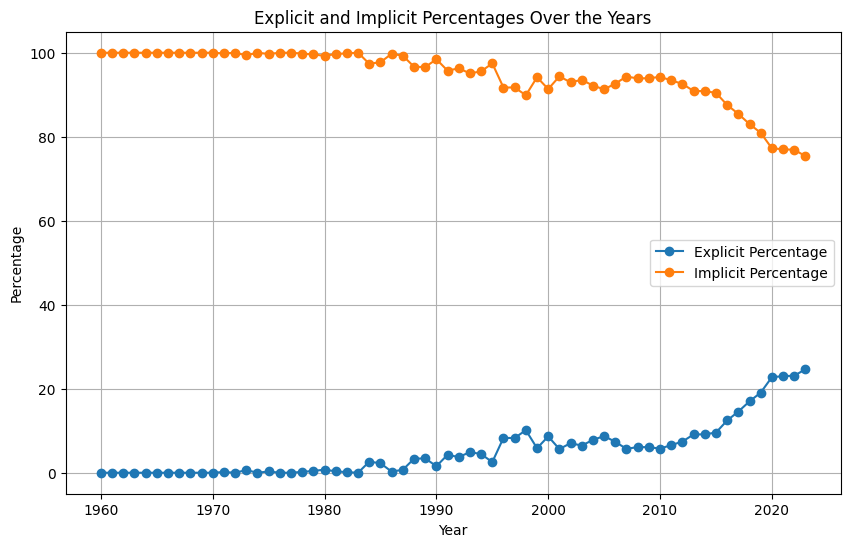

In [8]:
years                = [entry['year']               for entry in result_query2]
explicit_percentages = [entry['explicitPercentage'] for entry in result_query2]
implicit_percentages = [entry['implicitPercentage'] for entry in result_query2]

plt.figure(figsize=(10, 6))
plt.plot(years, explicit_percentages, label='Explicit Percentage', marker='o')
plt.plot(years, implicit_percentages, label='Implicit Percentage', marker='o')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Explicit and Implicit Percentages Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Query 3: get the average instrumentalness of the tracks based on its time signature,

In [9]:
query3 = [
    {
        '$group': {
            '_id': '$time_signature',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'},
            'average_valence': {'$avg': '$valence'}
        }
    },
    {
        '$sort': {
            '_id': 1
        }
    },
    {
        '$project': {
            '_id': 0,
            'time_signature': '$_id',
            'average_danceability': 1,
            'average_energy': 1,
            'average_valence': 1
        }
    }
]

In [11]:
result_query3 = list(features.aggregate(query3))

In [16]:
for entry in result_query3:
    print(entry)

{'average_danceability': 0.003404432132963989, 'average_energy': 0.26101595844875347, 'average_valence': 0.002557756232686981, 'time_signature': 0}
{'average_danceability': 0.4136496569037657, 'average_energy': 0.36219480560669454, 'average_valence': 0.3145970180753138, 'time_signature': 1}
{'average_danceability': 0.43975479951664287, 'average_energy': 0.3548632672547512, 'average_valence': 0.3370189773393387, 'time_signature': 3}
{'average_danceability': 0.5977182066425011, 'average_energy': 0.5571829159586544, 'average_valence': 0.47963527953251917, 'time_signature': 4}
{'average_danceability': 0.4467058143296135, 'average_energy': 0.39166122789099145, 'average_valence': 0.3187189199417758, 'time_signature': 5}


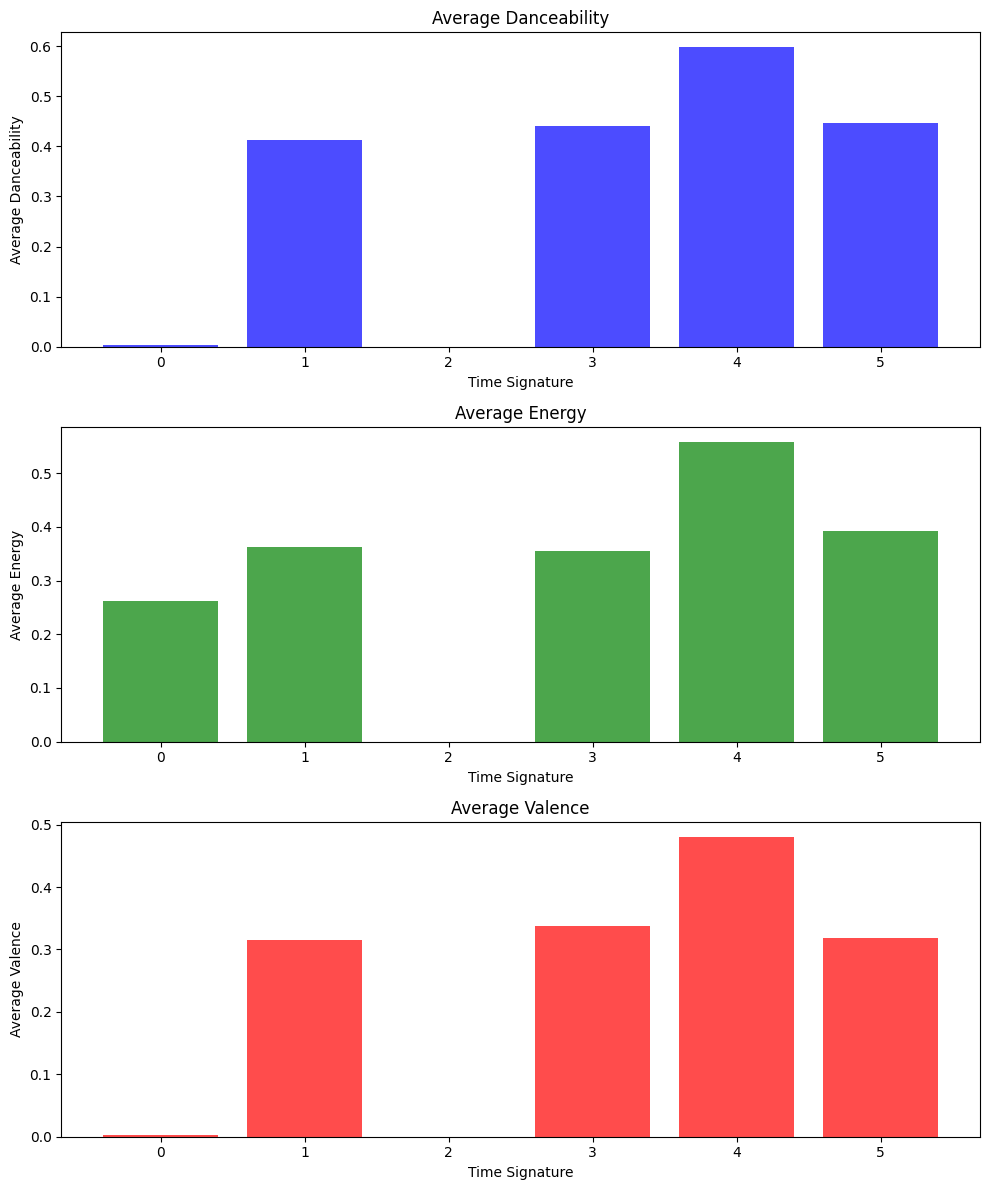

In [20]:
danceability    = [entry['average_danceability'] for entry in result_query3]
energy          = [entry['average_energy'] for entry in result_query3]
valence         = [entry['average_valence'] for entry in result_query3]
time_signatures = [entry['time_signature'] for entry in result_query3]

# Plotting histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot for Average Danceability
axs[0].bar(time_signatures, danceability, color='blue', alpha=0.7)
axs[0].set_title('Average Danceability')
axs[0].set_xlabel('Time Signature')
axs[0].set_ylabel('Average Danceability')

# Plot for Average Energy
axs[1].bar(time_signatures, energy, color='green', alpha=0.7)
axs[1].set_title('Average Energy')
axs[1].set_xlabel('Time Signature')
axs[1].set_ylabel('Average Energy')

# Plot for Average Valence
axs[2].bar(time_signatures, valence, color='red', alpha=0.7)
axs[2].set_title('Average Valence')
axs[2].set_xlabel('Time Signature')
axs[2].set_ylabel('Average Valence')

plt.tight_layout()
plt.show()

#### Interpretation

## Query 4: find artists popular only in few albums
Useful for instance if you want to find underground artists that collaborate with big stars.Very likely in those album the one with low popularity will have a big album popularity in that album. Useful also to spot artists that, for instance, wrote a summer-hit but for the rest of the year no one listen to him. The query works by finding the stardard deviation of the artist's albums popularity. Artists that only wrote 2 albums were discarted, as well as artist with low popularity (<50) to spot artists that we may know!

In [24]:
query4= [
    {
        "$lookup": {
            "from": "albums",
            "localField": "id",
            "foreignField": "artist_id",
            "as": "albums"
        }
    },
    {
        "$unwind": "$albums"
    },
    {
        "$group": {
            "_id": "$id",
            "name": {"$first": "$name"},
            "popularityArray": {"$push": "$albums.album_popularity"},
            "overall_popularity": {"$first": "$artist_popularity"}
        }
    },
    {
        "$project": {
            "name": 1,
            "overall_popularity": 1,
            "coefficientOfVariation": {
                "$cond": {
                    "if": {"$eq": [{"$avg": "$popularityArray"}, 0]},
                    "then": 0,
                    "else": {
                        "$divide": [
                            {"$stdDevSamp": "$popularityArray"},
                            {"$avg": "$popularityArray"}
                        ]
                    }
                }
            },
            "total_albums": {"$size": "$popularityArray"}
        }
    },
    {
        "$match": {
            "total_albums": {"$gt": 2},
            "overall_popularity": {"$gte": 40}
        }
    },
    {
        "$sort": {"coefficientOfVariation": -1}
    },
    {
        "$limit": 200
    }
]



result_query4 = artists.aggregate(query4)

In [25]:
display_results(result_query4)

{'_id': '0GQkTwFb7D3ePIpnxwYavf', 'name': 'Done Again', 'overall_popularity': 40, 'coefficientOfVariation': 6.085199811164736, 'total_albums': 710}
{'_id': '28Y5nsvbE8IdoUAGNgCk0Y', 'name': 'Marsha', 'overall_popularity': 42, 'coefficientOfVariation': 4.123105625617661, 'total_albums': 17}
{'_id': '4CDMSd6tmH66svpunz3aWP', 'name': 'Gerald Finzi', 'overall_popularity': 42, 'coefficientOfVariation': 3.8729833462074166, 'total_albums': 15}
{'_id': '00wclaNli3JTTLho4LPjBF', 'name': 'breezy brooks', 'overall_popularity': 51, 'coefficientOfVariation': 3.283041725144403, 'total_albums': 314}
{'_id': '0GM7qgcRCORpGnfcN2tCiB', 'name': 'Tainy', 'overall_popularity': 77, 'coefficientOfVariation': 2.775648839312855, 'total_albums': 23}
{'_id': '2QFXAOEj2ow8a3xVkD8Ntg', 'name': 'Ian Carey', 'overall_popularity': 41, 'coefficientOfVariation': 2.145911990647552, 'total_albums': 19}
{'_id': '2d09AaNvj1TRW0GociCEDY', 'name': 'Demi Femme', 'overall_popularity': 40, 'coefficientOfVariation': 2.0062836360

#### Interpretation: Maroon 5, Jhonny Cash, Robbie Williams, Will.I.am, jackson 5, royce da 5'9'', Gucci mane
Those are inconsistent artists in term of popularity

# Query 5
#### Query: Most important labels for each genre

In [41]:
query5 =[
    {
        "$lookup": {
            "from": "albums",
            "localField": "id",
            "foreignField": "artist_id",
            "as": "albums",
        },
    },
    {
        "$unwind": "$artist_genres",
    },
    {
        "$unwind": "$albums",
    },
    {
        "$group": {
            "_id": {
                "genre": "$artist_genres",
                "label": "$albums.label",
            },
            "averagePopularity": {"$avg": "$albums.album_popularity"},
        },
    },
    {
        "$sort": {
            "_id.genre": 1,
            "averagePopularity": -1,
        },
    },
    {
        "$group": {
            "_id": "$_id.label",
            "genres": {"$push": {"genre": "$_id.genre", "popularity": "$averagePopularity"}},
        },
    },
    {
        "$project": {
            "_id": 0,
            "mostImportantLabel": "$_id",
            "highestAveragePopularity": {"$max": "$genres.popularity"},
            "genres": "$genres.genre",
        },
    },
    {
        "$sort": {
            "highestAveragePopularity": -1,
        },
    },
    {
        "$limit": 200
    }
]
result_query5 = list(artists.aggregate(query5))

### Result

In [42]:
display_results(result_query5)

{'mostImportantLabel': 'Dead Oceans', 'highestAveragePopularity': 90.0, 'genres': ['brooklyn indie', 'indie pop', 'la indie', 'pov: indie']}
{'mostImportantLabel': 'Cash Money/Drake LP6', 'highestAveragePopularity': 87.0, 'genres': ['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap']}
{'mostImportantLabel': 'Slaughter Gang, LLC/Epic/Boominati Worldwide/Republic', 'highestAveragePopularity': 86.0, 'genres': ['atl hip hop', 'hip hop', 'rap']}
{'mostImportantLabel': 'Street Mob Records - Rancho Humilde', 'highestAveragePopularity': 85.0, 'genres': ['corrido', 'corridos tumbados', 'sad sierreno', 'sierreno']}
{'mostImportantLabel': 'Rimas Entertainment LLC', 'highestAveragePopularity': 84.18320610687023, 'genres': ['bachata', 'bachata dominicana', 'latin hip hop', 'latin pop', 'rap dominicano', 'reggaeton', 'reggaeton flow', 'trap boricua', 'trap latino', 'trap triste', 'tropical', 'urbano latino']}
{'mostImportantLabel': 'Kid Ina Korner / Interscope', 'highestAveragePopularit

In [39]:
result_query5


### Show only the first 50 most important labels (to better visualize the names)

In [46]:
labels = [entry['mostImportantLabel'] for entry in result_query5 if 'genres' in entry]
average_popularities = [entry['highestAveragePopularity'] for entry in result_query5 if 'genres' in entry]
labels = labels[0:50]
average_popularities = average_popularities[0:50]

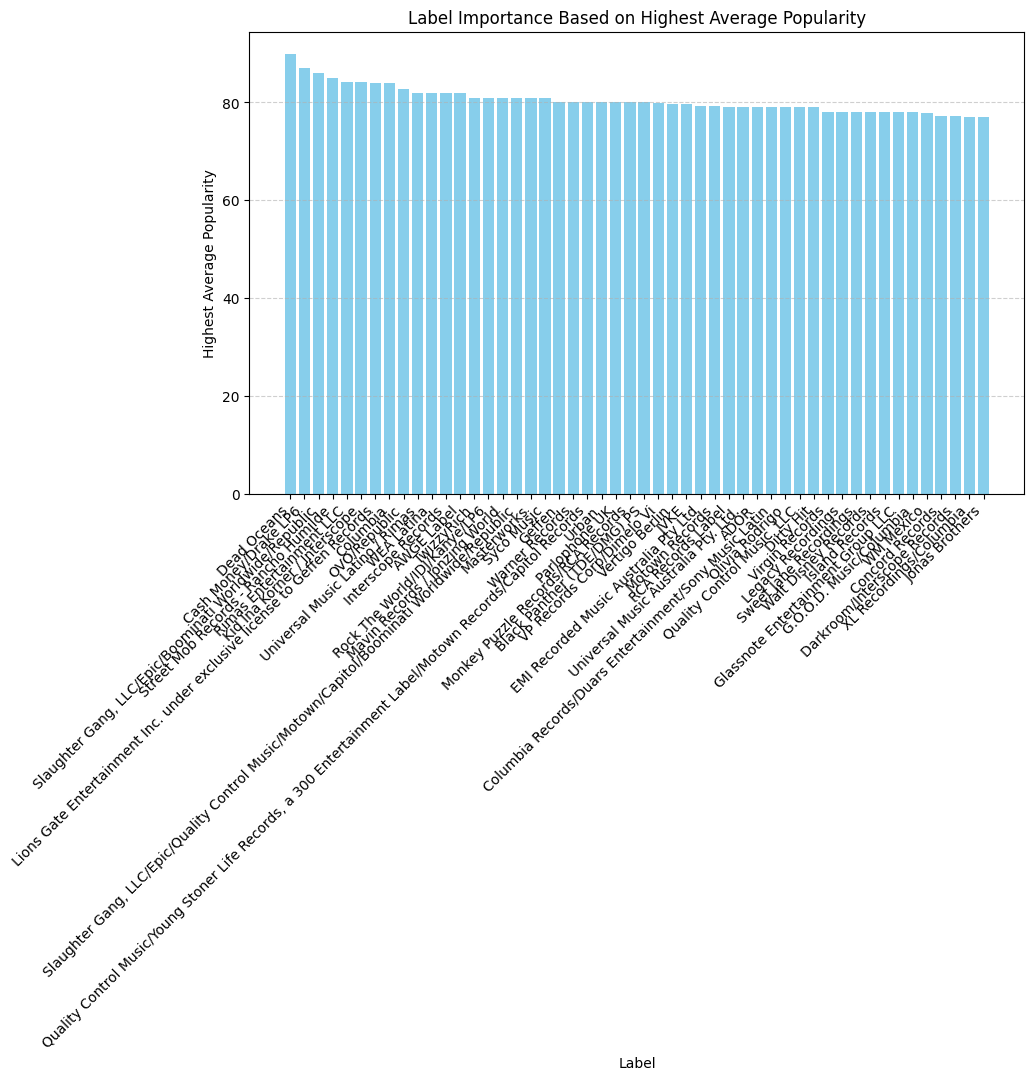

In [48]:

# Plotting as a histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, average_popularities, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Highest Average Popularity')
plt.title('Label Importance Based on Highest Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### Interpretation: 

## Query 6
##### Query: find label that release albums prevelently (more than 65%) in the summer


In [19]:
query6 = [
    {
        '$addFields': {
            'isSummer': {
                '$or': [
                    {'$eq': [{'$month': '$release_date'}, 6]},  # June
                    {'$eq': [{'$month': '$release_date'}, 7]}   # July
                ]
            }
        }
    },
    {
        '$group': {
            '_id': {
                'label': '$label',
                'album_name': '$album_name'
            },
            'totalAlbums': {'$sum': 1},
            'summerAlbums': {'$max': {'$cond': ['$isSummer', 1, 0]}}
        }
    },
    {
        '$group': {
            '_id': {
                'label': '$_id.label'
            },
            'totalAlbums': {'$sum': '$totalAlbums'},
            'summerAlbums': {'$sum': '$summerAlbums'}
        }
    },
    {
        '$project': {
            'label': '$_id.label',
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': {
                '$multiply': [{'$divide': ['$summerAlbums', '$totalAlbums']}, 100]
            }
        }
    },
    {
        '$match': {
            '$and': [
                {'totalAlbums': {'$gt': 7}},         # labels with at least 8 total albums
                {'percentageInSummer': {'$gt': 70}}  # labels with more than 70% summer albums
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'label': 1,
            'totalAlbums': 1,
            'summerAlbums': 1,
            'percentageInSummer': 1
        }
    },
    {
        '$sort': {'percentageInSummer': -1}  
    }
]

result_query6 = list(albums.aggregate(query6))

In [20]:
result_query6

[{'totalAlbums': 10,
  'summerAlbums': 10,
  'label': 'GWK quavon Doss',
  'percentageInSummer': 100.0},
 {'totalAlbums': 97,
  'summerAlbums': 96,
  'label': 'Ocean Distribution FZCO',
  'percentageInSummer': 98.96907216494846},
 {'totalAlbums': 8,
  'summerAlbums': 7,
  'label': '864347 Records DK',
  'percentageInSummer': 87.5},
 {'totalAlbums': 10,
  'summerAlbums': 8,
  'label': 'DJ Stanz',
  'percentageInSummer': 80.0},
 {'totalAlbums': 9,
  'summerAlbums': 7,
  'label': 'Metro Music Creative',
  'percentageInSummer': 77.77777777777779}]

#### Interpretation: